In [ ]:
!pip install numpy matplotlib

In [ ]:

## Imports

import random as rd
import matplotlib.pyplot as plt
import numpy as np

## Global variables

# Number of alternatives, denoted a, b, c, ..., n respectively
M_ALTERNATIVES = 2

# Amount of evidence there is for a as well as b
A_EVIDENCE = 3
B_EVIDENCE = 2

# Global constant to adjust probability of gaining pieces of evidence
P_COMPETENCE = 0.6

## Helper functions

def first_non_zero(arr):
    for element in arr:
        if element != 0:
            return element
    return None  # If all elements are zero, return None

## Defining Classes

class DeliberationSetting:
    def __init__(self, no_of_agents=5, a_evidence=3, b_evidence=2, p_competence=0.6):
        '''if no_of_agents % 2 == 0:
            raise ValueError("Behold, number of agents must be odd!")'''

        self.number_of_agents = no_of_agents
        self.A_EVIDENCE = a_evidence
        self.B_EVIDENCE = b_evidence
        self.P_COMPETENCE = p_competence

        self.crowd = Crowd(no_of_agents=self.number_of_agents, p_competence=self.P_COMPETENCE, a_evidence=self.A_EVIDENCE, b_evidence=self.B_EVIDENCE)

    def run_sim_keen(self):
        return self.crowd.deliberate_sim()


class Agent:

    def __init__(self, p_competence=0.6, a_evidence = 3, b_evidence = 2):

        self.P_COMPETENCE = p_competence
        self.A_EVIDENCE = a_evidence
        self.B_EVIDENCE = b_evidence

        self.es_A, self.es_B = self.sample_evidence() # Takes predefined evidence sets in, TBD adjust if necessary

        # Bool arrays to indicate whether a piece of evidence was learned from others or not
        self.es_A_acquired = [0] * self.A_EVIDENCE
        self.es_B_acquired = [0] * self.B_EVIDENCE

        self.update_top_keen() # Finds top alternative based on size of respective evidence sets

    def sample_evidence(self):
        evidence_for_a = [None] * self.A_EVIDENCE
        evidence_for_b = [None] * self.B_EVIDENCE

        # Fill evidence_for_a
        for i in range(len(evidence_for_a)):
            if rd.uniform(0, 1) <= self.P_COMPETENCE:
                evidence_for_a[i] = 1
            else:
                evidence_for_a[i] = 0

        # Fill evidence_for_b
        for i in range(len(evidence_for_b)):
            if rd.uniform(0, 1) <= self.P_COMPETENCE:
                evidence_for_b[i] = 1
            else:
                evidence_for_b[i] = 0

        return evidence_for_a, evidence_for_b

    # Determines current favorite
    def update_top_keen(self):
        # Count the number of ones in each list
        count_a = self.es_A.count(1)
        count_b = self.es_B.count(1)

        # Set self.top based on which list has more ones
        if count_a > count_b:
            self.top = 'A'
        elif count_b > count_a:
            self.top = 'B'
        else:
            # Handle the undecided state when counts are equal
            #raise ValueError("Agent undecided! What to do now?")

            self.top = 'X' # Stands for indifference or equal evidence

    ''' # Learning new pieces of evidence: Increases evidence set for either option A or B
    def learn_for(self, option, evidence_index):
        if option in ['A', 'B']:
            # Construct the attribute name based on the input
            es_name = f'es_{option}'
            es_name_acquired = f'{es_name}_acquired'

            # Retrieve the attribute (list) using getattr
            attr_list = getattr(self, es_name)
            acquired_list = getattr(self, es_name_acquired)

            # Ensure the evidence index is within valid range (1-based to 0-based)
            if 1 <= evidence_index <= len(attr_list):
                zero_index = evidence_index - 1
                attr_list[zero_index] = 1  # Set the specific index to 1
                acquired_list[zero_index] = 1 # Sets acquired index for the corresponding element to 1
            else:
                print(f"Error: evidence_index {evidence_index} is out of range.")

            # Update preferred option
            self.update_top()
        else:
            # handle invalid input for A
            print(f"Invalid option: {option}. Please choose 'A' or 'B'.")'''

class Crowd: # Some sort of dynamic process tracker / protocol initally, now a collective of agents

    def __init__(self, no_of_agents=5, p_competence=0.6, a_evidence=3, b_evidence=2):

        self.A_EVIDENCE = a_evidence
        self.B_EVIDENCE = b_evidence
        self.P_COMPETENCE = p_competence

        #if no_of_agents % 2 == 1:
        self.agents = [Agent(p_competence=self.P_COMPETENCE, a_evidence=self.A_EVIDENCE, b_evidence=self.B_EVIDENCE) for _ in range(no_of_agents)]
        #else:
           # raise ValueError("Number of agents must be odd.")

        self.public_evidence_A = [0] * len(self.agents[0].es_A)
        self.public_evidence_B = [0] * len(self.agents[0].es_B)
    # In case anything goes wrong and number needs to be readjusted

    def set_no_of_agents(self, number):
        self.no_of_agents = number

    def generate_profile(self, agents):
        profile = [None] * len(agents)

        # For each agent, call their top-ranked alternative and save it in a index-corresponding array
        for i in range(len(agents)):
            profile[i] = getattr(agents[i], 'top')

        return profile


    def get_winner(self, profile):
        profile = profile

        count_a = 0
        count_b = 0

        # Iterate over the array to count occurrences
        for char in profile:

            if char == 'A':
                count_a += 1

            elif char == 'B':
                count_b += 1

            # ! In case of indifference: Do nothing
            elif char == 'X':
                continue
            else:
                raise ValueError("Input array should only contain 'A' and 'B'.")

        # Compare counts to determine which letter is more frequent
        if count_a > count_b:
            return 'A'
        elif count_b > count_a:
            return 'B'
        else:
            print("Tie! Adjust number of agents using set_no_of_agents.")
            return 'X'

    # TBD: might be able to use this method for lazy dissenters as well and only ajust the update_top function of the agents
    def dissenters_keen(self, profile):
        profile = profile
        winner = self.get_winner(profile) # This may be dangerous to do? Maybe control this variable outside the method.

        # Initialize boolean array to indicate whether agent dissents or not
        dissent = [None] * len(profile)

        i = 0
        while i < len(profile):
            if profile[i] != winner: # This works for keen dissenters, since 'X' is not 'A', so this loop would activate for indifference
                # Handling the special case of an indifferent agent
                if profile[i] == 'X':
                    dissent[i] = 'B' if winner == 'A' else 'A'
                    # We dont need to handle case 'X' here, since then the bigger encasing if clause would not be true since X = X.
                else:
                    dissent[i] = profile[i]
            i += 1

        return dissent

    # Terminal plotter for evidence distribution
    def plot_agent_evidence(self, agents):
         # Marker for each agent
         i = 1
         for agent in agents:
            print(i)
            i += 1

            es_A_own = 0
            es_B_own = 0

            # Count private evidence, which is in the evidence set but not in the acquired set
            for j in range(len(agent.es_A)):
                if agent.es_A[j] == 1 and agent.es_A_acquired[j] == 0:
                    es_A_own += 1

            for k in range(len(agent.es_B)):
                if agent.es_B[k] == 1 and agent.es_B_acquired[k] == 0:
                    es_B_own += 1

            # Distinugish between private and acquired evidence
            print("Evidence A: " + "█" * es_A_own + "▒" * agent.es_A_acquired.count(1))
            print("Evidence B: " + "█" * es_B_own + "▒" * agent.es_B_acquired.count(1))

    def deliberate_sim(self):

        # Counts how many round of deliberation we have
        round = 0

        # Return reason for return statement
        ret_reason = None

        # Intialize important variables
        profile = self.generate_profile(self.agents)
        print(profile) # ___Printer___
        majority = self.get_winner(profile)
        minority = 'A' if majority == 'B' else 'B'
        revealed_in_round_A = [0] * self.A_EVIDENCE
        revealed_in_round_B = [0] * self.B_EVIDENCE

        # Initialize dissenters
        dissenters = self.dissenters_keen(profile)
        print('First dissenters:', dissenters)

        print('First majority vote:', majority) # ____Printer____
        print()

        while dissenters != [None] * len(self.agents):

            # Start of a new round
            round += 1

            # Revelation marker: If there exists a piece of evidence that was revealed during a round, it is true. Otherwise, deliberation terminates.
            new_evidence_revealed = False

            # For all dissenters, add their evidence for the minority alternative into the revealed evidence sets

            for i, is_dissenter_letter in enumerate(dissenters):
                if is_dissenter_letter != None:
                    # Get the set of evidence for the minority option from each dissenter
                    dissenter_evidence = f'es_{is_dissenter_letter}'
                    dissenter_evidence = getattr(self.agents[i], dissenter_evidence)
                    print(f'Agent {i} s dissenter_evidence for the minority {is_dissenter_letter}: ', dissenter_evidence) # ___Printer___

                    # Update the revealed_in_round sets to take on the the revealed evidence (only one if-clause will be activated)
                    if is_dissenter_letter == 'A':
                        for j in range(len(dissenter_evidence)):
                            if dissenter_evidence[j] == 1 and revealed_in_round_A[j] != 1:
                                revealed_in_round_A[j] = 1
                                new_evidence_revealed = True # Sets revealed marker to true

                                print(f'Revealing new evidence {j} for minority option {minority} from agent {i}') # ___Printer___
                    if is_dissenter_letter == 'B':
                        for k in range(len(dissenter_evidence)):
                            if dissenter_evidence[k] == 1 and revealed_in_round_B[k] != 1:
                                revealed_in_round_B[k] = 1
                                new_evidence_revealed = True # Sets revealed marker to true

                                print(f'Revealing new evidence {k} for minority option {minority} from agent {i}') # ___Printer___

            # If no new evidence was revealed, break the loop
            if not new_evidence_revealed:
                ret_reason = 'No more evidence to reveal from dissenters.'
                break

            # Add all the evidence to the public evidence sets for A and B cumulatively
            for i in range(len(revealed_in_round_A)):
                if revealed_in_round_A[i] == 1:
                    self.public_evidence_A[i] = 1

            for i in range(len(revealed_in_round_B)):
                if revealed_in_round_B[i] == 1:
                    self.public_evidence_B[i] = 1

            # Update the indivdual evidence sets of agents to take on the revealed evidence
            for agent in self.agents:

                # Update evidence for A with public evidence
                for i in range(len(self.public_evidence_A)):
                    if self.public_evidence_A[i] == 1 and agent.es_A[i] != 1:
                        agent.es_A[i] = 1
                        agent.es_A_acquired[i] = 1 # Mark as acquired information

                # Update evidence for B with public evidence
                for i in range(len(self.public_evidence_B)):
                    if self.public_evidence_B[i] == 1 and agent.es_B[i] != 1:
                        agent.es_B[i] = 1
                        agent.es_B_acquired[i] = 1 # Mark as acquired information

                agent.update_top_keen()  # Update each agents favorite option

            # Update profile, majority and minority
            self.profile = self.generate_profile(self.agents)
            print('New profile: ', self.profile) # ___Printer___

            majority = self.get_winner(self.profile)
            print('Newly assigned majority: ', majority) #___Printer___

            minority = 'A' if majority == 'B' else 'B'
            print('Newly assgined minority: ', minority) #___Printer___

            # Update dissenters
            dissenters = self.dissenters_keen(self.profile)
            print("Dissenters: ", dissenters) # ___Printer___

        print('Generating plot for deliberation end result...')
        self.plot_agent_evidence(self.agents)

        print(f'_______________WINNER {self.get_winner(self.generate_profile(self.agents))}.______________')
        print(f'Termination at round {round}: No more dissenters.' if ret_reason == None else f'Termination at round {round}: {ret_reason}')
        return self.get_winner(self.generate_profile(self.agents))


# Running the simulations

test_crowd = Crowd()

test_crowd.deliberate_sim()










['A', 'A', 'A', 'B', 'A']
First dissenters: [None, None, None, 'B', None]
First majority vote: A

Agent 3 s dissenter_evidence for the minority B:  [1, 1]
Revealing new evidence 0 for minority option B from agent 3
Revealing new evidence 1 for minority option B from agent 3
New profile:  ['A', 'X', 'X', 'B', 'X']
Tie! Adjust number of agents using set_no_of_agents.
Newly assigned majority:  X
Newly assgined minority:  B
Tie! Adjust number of agents using set_no_of_agents.
Dissenters:  ['A', None, None, 'B', None]
Agent 0 s dissenter_evidence for the minority A:  [1, 1, 1]
Revealing new evidence 0 for minority option B from agent 0
Revealing new evidence 1 for minority option B from agent 0
Revealing new evidence 2 for minority option B from agent 0
Agent 3 s dissenter_evidence for the minority B:  [1, 1]
New profile:  ['A', 'A', 'A', 'A', 'A']
Newly assigned majority:  A
Newly assgined minority:  B
Dissenters:  [None, None, None, None, None]
Generating plot for deliberation end result.

'A'

## Naive deliberation

In [ ]:
i = 100
results = []

while i != 0:
    setting = DeliberationSetting(a_evidence=9, b_evidence = 7, p_competence=0.3)
    deliberation_result = setting.run_sim_keen()
    results.append(deliberation_result)
    i -= 1


print('--------')
print('FINAL Result: ',results)

['A', 'A', 'A', 'A', 'B']
First dissenters: [None, None, None, None, 'B']
First majority vote: A

Agent 4 s dissenter_evidence for the minority B:  [1, 1, 0, 0, 0, 1, 0]
Revealing new evidence 0 for minority option B from agent 4
Revealing new evidence 1 for minority option B from agent 4
Revealing new evidence 5 for minority option B from agent 4
New profile:  ['X', 'X', 'B', 'A', 'B']
Newly assigned majority:  B
Newly assgined minority:  A
Dissenters:  ['A', 'A', None, 'A', None]
Agent 0 s dissenter_evidence for the minority A:  [0, 0, 0, 1, 0, 1, 0, 0, 1]
Revealing new evidence 3 for minority option A from agent 0
Revealing new evidence 5 for minority option A from agent 0
Revealing new evidence 8 for minority option A from agent 0
Agent 1 s dissenter_evidence for the minority A:  [1, 0, 0, 0, 1, 1, 0, 0, 0]
Revealing new evidence 0 for minority option A from agent 1
Revealing new evidence 4 for minority option A from agent 1
Agent 3 s dissenter_evidence for the minority A:  [1, 0, 

## Asymptotic n approximation

Streaming output truncated to the last 5000 lines.
Evidence A: █████▒
Evidence B: ▒▒▒▒▒
10
Evidence A: ████▒▒
Evidence B: █████
11
Evidence A: ███▒▒▒
Evidence B: ████▒
12
Evidence A: ██▒▒▒▒
Evidence B: ██▒▒▒
13
Evidence A: ██▒▒▒▒
Evidence B: ███▒▒
14
Evidence A: ██▒▒▒▒
Evidence B: █████
15
Evidence A: █████▒
Evidence B: ███▒▒
16
Evidence A: █████▒
Evidence B: █▒▒▒▒
17
Evidence A: ███▒▒▒
Evidence B: ██▒▒▒
18
Evidence A: ████▒▒
Evidence B: ███▒▒
19
Evidence A: ██▒▒▒▒
Evidence B: ███▒▒
20
Evidence A: ████▒▒
Evidence B: ████▒
21
Evidence A: ████▒▒
Evidence B: ██▒▒▒
22
Evidence A: ██▒▒▒▒
Evidence B: ████▒
23
Evidence A: ████▒▒
Evidence B: ███▒▒
24
Evidence A: ████▒▒
Evidence B: ██▒▒▒
25
Evidence A: ████▒▒
Evidence B: ███▒▒
26
Evidence A: ████▒▒
Evidence B: ██▒▒▒
27
Evidence A: ████▒▒
Evidence B: ████▒
28
Evidence A: ████▒▒
Evidence B: █▒▒▒▒
29
Evidence A: █▒▒▒▒▒
Evidence B: ██▒▒▒
30
Evidence A: ███▒▒▒
Evidence B: █████
_______________WINNER A.______________
Termination at round 2: No more d

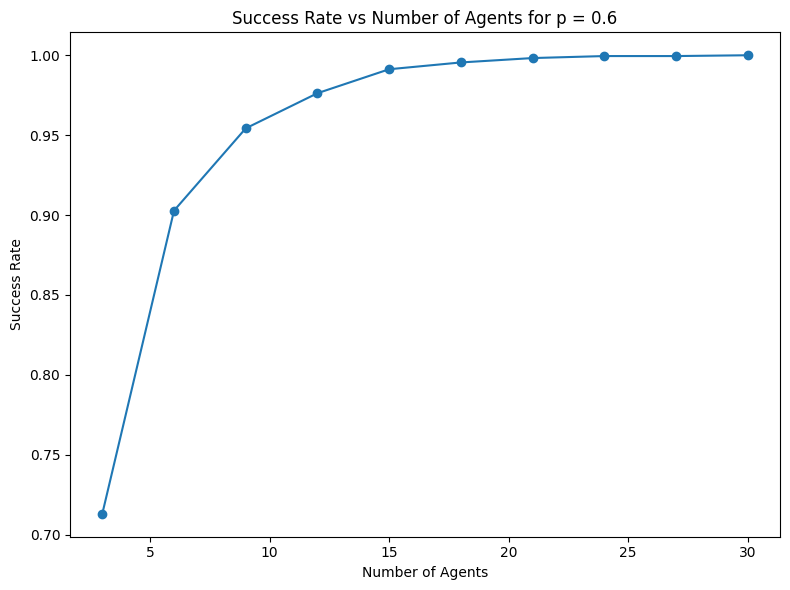

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

iterations_per_agent = 1000
competence = 0.6
agent_counts = [3,6,9,12,15,18,21,24,27,30,33] # Number of agents from 2 to 10

# Array with values showing success rate corresponding to number of agents
success_rates = []

for agents in agent_counts:
    single_round_successes = []
    ties = 0


    j = 0
    # Run specified number of times
    while j < iterations_per_agent:

        deliberation_setting = DeliberationSetting(p_competence = 0.6, a_evidence=6, b_evidence=5, no_of_agents=agents)
        result = deliberation_setting.run_sim_keen()

        if result is not None:
            single_round_successes.append(result)
            j += 1
        else:
            single_round_successes.append(result)
            j +=1

    # Calculate relative success
    success_rate = single_round_successes.count('A') / iterations_per_agent
    success_rates.append(success_rate)

# Generate the new plot with number of agents vs success rate
plt.figure(figsize=(8, 6))

plt.title("Success Rate vs Number of Agents for p = 0.6")
plt.xlabel("Number of Agents")
plt.ylabel("Success Rate")
plt.plot(agent_counts, success_rates, marker='o')

plt.tight_layout()
plt.show()


## Group competence calculations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

# Sample data for success rates
agent_counts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
p_competence = 0.6

def condorcet(n, p):
    sum_result = 0
    for i in range((n // 2) + 1, n + 1):
        binom_coeff = scipy.special.comb(n, i)
        term = binom_coeff * (p ** i) * ((1 - p) ** (n - i))
        sum_result += term
    return sum_result

# Compute Condorcet values for the given range of agent counts
condorcet_values = [condorcet(n, p_competence) for n in agent_counts]

# Diagnostic print to understand the behavior of condorcet values
for n, value in zip(agent_counts, condorcet_values):
    print(f'Agents: {n}, Condorcet Value: {value}')

# Plot success rates and Condorcet values
plt.figure(figsize=(10, 6))

plt.plot(agent_counts, success_rates, marker='o', label='Success Rates')
plt.plot(agent_counts, condorcet_values, marker='x', label='Condorcet Values')

plt.title("Success Rates and Condorcet Values vs Number of Agents")
plt.xlabel("Number of Agents")
plt.ylabel("Success Rate / Condorcet Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Agents: 3, Condorcet Value: 0.648
Agents: 6, Condorcet Value: 0.54432
Agents: 9, Condorcet Value: 0.7334323199999999
Agents: 12, Condorcet Value: 0.6652085575679999
Agents: 15, Condorcet Value: 0.786896817389568
Agents: 18, Condorcet Value: 0.7368411690211737
Agents: 21, Condorcet Value: 0.8256221336382271
Agents: 24, Condorcet Value: 0.7869782010394586
Agents: 27, Condorcet Value: 0.85534823563728
Agents: 30, Condorcet Value: 0.8246309464931707


NameError: name 'success_rates' is not defined

<Figure size 1000x600 with 0 Axes>

## Proof Bound Outbid

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np

# SPECIAL METHOD We also give back if this is an a-majority
def amaj_agents_strong_competence(no_of_agents, competence, a_evidence, b_evidence):
    agents = [Agent(a_evidence=a_evidence, b_evidence=b_evidence, p_competence=competence) for _ in range(no_of_agents)]
    a_agents = 0

    for agent in agents:
        if agent.es_A.count(1) > agent.es_B.count(1):
            a_agents += 1  # Only add the agent if it has more evidence for A than B

    y_random_variable = 0

    for agent in agents:
        if competence * agent.es_A.count(1) > agent.es_B.count(1):
            y_random_variable += 1

    a_majority = True if a_agents > (no_of_agents - a_agents) else False

    return y_random_variable, a_majority

  # We generate n agents and give back the variable for how much evidence they have
def agents_strong_competence(no_of_agents, competence, a_evidence, b_evidence):
  agents = [Agent(a_evidence=a_evidence, b_evidence=b_evidence, p_competence=competence) for _ in range(no_of_agents)]

  y_random_variable = 0

  for agent in agents:
      if competence * agent.es_A.count(1) > agent.es_B.count(1):
          y_random_variable += 1

  return y_random_variable

def agents_wlln(no_of_agents, competence, a_evidence, b_evidence):
    agents = [Agent(a_evidence=a_evidence, b_evidence=b_evidence, p_competence=competence) for _ in range(no_of_agents)]

    evidence_A = []

    for agent in agents:
      evidence_A.append(agent.es_A.count(1))
      print(agent.es_A.count(1))

    return evidence_A

def binomial_coefficient(n, k):
    return math.comb(n, k)

def group_competency(a, b, p):
    total_sum = 0

    for bi in range(b + 1):
        for k in range(a - bi + 1):
            term = (binomial_coefficient(a, bi + k) *
                    binomial_coefficient(b, bi) *
                    p**(2 * bi + k) *
                    (1 - p)**(a + b - (2 * bi + k)))
            total_sum += term

    return total_sum

def wlln(a_evidence, p_competence, b_evidence):
    agent_numbers = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 250, 300]
    results = {n: [] for n in agent_numbers}
    bounds = [p_competence * a_evidence] * len(agent_numbers)

    for n in agent_numbers:
        for _ in range(20):
            result = agents_wlln(n, p_competence, a_evidence, b_evidence)
            results[n].append(result)

    for n in agent_numbers:
        for i in range(20):
            plt.scatter([n] * len(results[n][i]), results[n][i], color='blue')

def statistical_wlln (a_evidence, p_competence, b_evidence):
    agent_numbers = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 250, 300]
    means = []
    variances = []
    bounds = [p_competence * a_evidence] * len(agent_numbers)

    for n in agent_numbers:
        evidence_counts = []
        for _ in range(20):
            result = agents_wlln(n, p_competence, a_evidence, b_evidence)
            evidence_counts.extend(result)

        mean_evidence = np.mean(evidence_counts)
        variance_evidence = np.var(evidence_counts)

        means.append(mean_evidence)
        variances.append(variance_evidence)

    plt.figure(figsize=(12, 6))
    plt.errorbar(agent_numbers, means, yerr=np.sqrt(variances), fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label='Mean Evidence A with Variance')
    plt.plot(agent_numbers, bounds, color='red', label='Bound Points')
    plt.xlabel('Number of Agents')
    plt.ylabel('Evidence A')
    plt.title('Mean and Variance of Evidence A')
    plt.legend()
    plt.show()

def generate_data(a_evidence, b_evidence, p_competence):
    agent_numbers = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 250, 300]
    results = {n: [] for n in agent_numbers}
    bounds = []

    for n in agent_numbers:
        bound = n * (group_competency(a_evidence, b_evidence, p_competence) - 0.5)
        bounds.append(bound)

        for _ in range(20):  # Run the function 20 times for each number of agents
            result = agents_strong_competence(n, p_competence, a_evidence, b_evidence)
            results[n].append(result)

    # Plotting the results
    for n in agent_numbers:
        plt.scatter([n]*20, results[n], color='blue')  # Match the length of x and y

    plt.scatter(agent_numbers, bounds, color='red', label='Bound Points')
    plt.xlabel('Number of Agents')
    plt.ylabel('Value of Y')
    plt.title('Value of Y for Number of Agents')
    plt.legend()
    plt.show()


def amaj_generate_data(a_evidence, b_evidence, p_competence):
    agent_numbers = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 250, 300]
    results = {n: [] for n in agent_numbers}
    bounds = []

    for n in agent_numbers:
        bound = n * (group_competency(a_evidence, b_evidence, p_competence) - 0.5)
        bounds.append(bound)

        while len(results[n]) < 20:  # Run the function 20 times for each number of agents
            result, amaj = amaj_agents_strong_competence(n, p_competence, a_evidence, b_evidence)
            if amaj:
              results[n].append(result)


    # Plotting the results
    for n in agent_numbers:
        plt.scatter([n]*20, results[n], color='blue')  # Match the length of x and y

    plt.scatter(agent_numbers, bounds, color='red', label='Bound Points')
    plt.xlabel('Number of Agents')
    plt.ylabel('Value of Y')
    plt.title('Value of Y for Number of Agents')
    plt.legend()
    plt.show()


def generate_data_mean(a_evidence, b_evidence, p_competence):
  agent_numbers = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 250, 300]
  results = {n: [] for n in agent_numbers}
  mean_values = []
  variances = []
  bounds = []

  for n in agent_numbers:
      agent_results = []
      for _ in range(20):  # Run the function 20 times for each number of agents
          result = agents_strong_competence(n, p_competence, a_evidence, b_evidence)
          agent_results.append(result)

      results[n] = agent_results
      mean_value = np.mean(agent_results)
      variance = np.var(agent_results)
      mean_values.append(mean_value)
      variances.append(variance)

      bound = n * (group_competency(a_evidence, b_evidence, p_competence) - 0.5)
      bounds.append(bound)

  # Plotting the results
  plt.errorbar(agent_numbers, mean_values, yerr=np.sqrt(variances), fmt='o', color='blue', label='Mean and Variance')
  plt.scatter(agent_numbers, bounds, color='red', label='Bound Points')
  plt.xlabel('Number of Agents')
  plt.ylabel('Value of Y')
  plt.title('Mean and Variance of Y for Number of Agents')
  plt.legend()
  plt.show()

def amaj_generate_data_mean(a_evidence, b_evidence, p_competence):
  agent_numbers = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 250, 300]
  results = {n: [] for n in agent_numbers}
  mean_values = []
  variances = []
  bounds = []

  for n in agent_numbers:
      agent_results = []
      bound = n * (group_competency(a_evidence, b_evidence, p_competence) - 0.5)
      bounds.append(bound)

      while len(agent_results) < 20:  # Run the function 20 times for each number of agents
          result, amaj = amaj_agents_strong_competence(n, p_competence, a_evidence, b_evidence)
          if amaj:  # Assuming amaj is True when the condition is met
              agent_results.append(result)

      results[n] = agent_results
      mean_value = np.mean(agent_results)
      variance = np.var(agent_results)
      mean_values.append(mean_value)
      variances.append(variance)

  # Plotting the results
  plt.errorbar(agent_numbers, mean_values, yerr=np.sqrt(variances), fmt='o', color='blue', label='Mean and Variance')
  plt.scatter(agent_numbers, bounds, color='red', label='Bound Points')
  plt.xlabel('Number of Agents')
  plt.ylabel('Value of Y')
  plt.title('Mean and Variance of Y for Number of Agents')
  plt.legend()
  plt.show()


Streaming output truncated to the last 5000 lines.
5
5
6
4
6
5
4
5
6
5
4
4
5
3
4
3
5
4
5
5
3
4
4
5
3
6
6
5
4
6
4
6
2
5
4
4
5
4
6
4
4
3
4
4
5
4
4
4
4
3
4
5
6
4
5
4
4
3
4
5
3
5
5
4
5
4
4
4
4
2
5
2
6
3
5
4
3
6
4
4
5
4
4
3
4
5
2
5
4
4
4
3
4
4
5
4
3
5
4
3
3
4
3
5
4
6
3
4
4
4
6
4
4
4
4
6
5
3
4
5
4
4
5
5
4
5
5
3
2
4
5
4
5
6
5
6
5
4
4
4
4
2
6
4
5
3
3
3
5
3
4
2
6
4
5
5
4
5
5
4
3
4
3
6
5
3
5
5
4
6
3
5
5
4
5
5
4
6
5
4
6
3
4
4
4
3
4
3
4
5
5
2
5
4
5
5
5
3
6
5
3
3
5
2
5
5
4
5
2
4
5
4
3
5
5
2
6
4
4
3
6
5
6
5
6
4
5
4
5
4
3
4
4
5
4
2
4
6
5
1
4
5
5
4
3
5
3
6
4
4
4
4
3
4
3
4
4
5
3
4
2
5
3
5
4
6
4
6
6
4
3
3
4
5
6
5
3
6
1
5
2
5
5
2
5
6
6
4
2
3
4
3
5
6
4
4
5
3
5
4
2
2
3
2
3
4
3
5
5
5
4
5
4
4
4
2
3
3
6
3
4
4
4
5
5
3
6
4
6
6
3
3
3
5
3
4
4
4
4
5
6
4
4
5
3
3
5
4
5
5
6
5
3
5
6
5
5
4
5
4
6
5
2
5
4
3
5
3
4
5
5
4
4
3
6
5
4
6
5
2
4
3
4
5
1
3
5
4
4
5
5
5
5
4
4
4
5
5
3
2
5
5
4
3
3
3
4
4
2
3
2
3
4
5
5
3
3
5
5
5
4
6
4
5
3
3
6
3
5
4
3
3
5
3
5
3
6
4
5
4
4
5
4
5
5
4
4
4
5
3
6
4
2
5
4
5
3
4
3
3
4
3
5
3
4
4
6
1
6
1
6
5
2
3
3

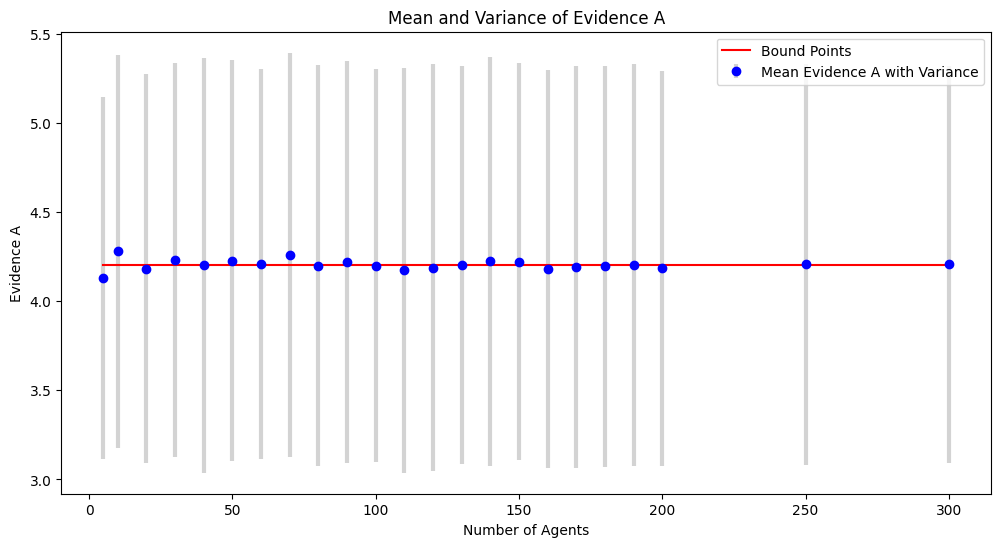

In [ ]:
statistical_wlln(a_evidence=6, p_competence=0.7, b_evidence=5)

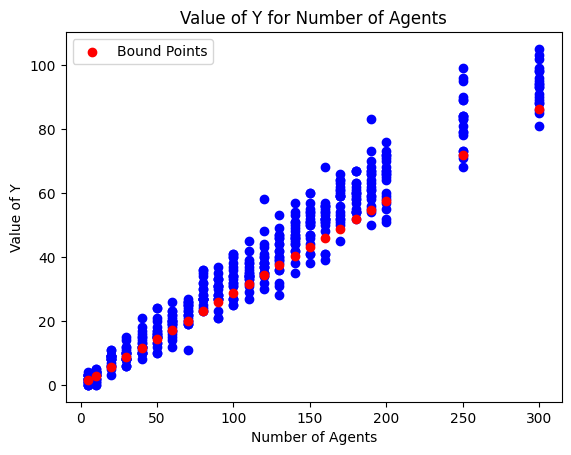

In [ ]:
generate_data(a_evidence=6, b_evidence=5, p_competence=0.7)

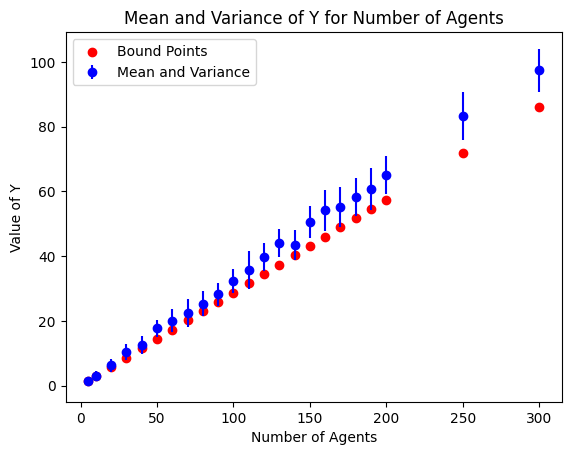

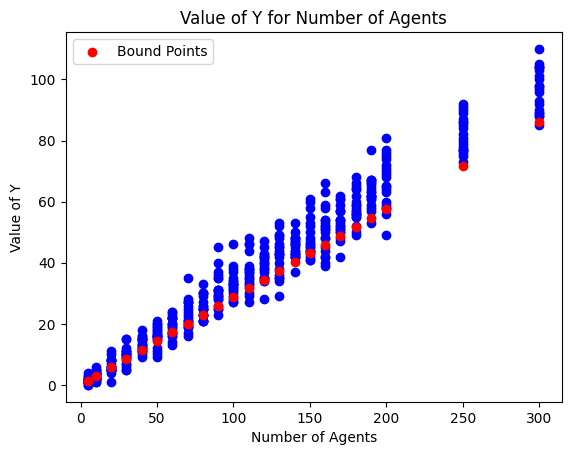

In [ ]:
generate_data_mean(a_evidence=6, b_evidence = 5, p_competence=0.7)
generate_data(a_evidence=6, b_evidence=5, p_competence=0.7)

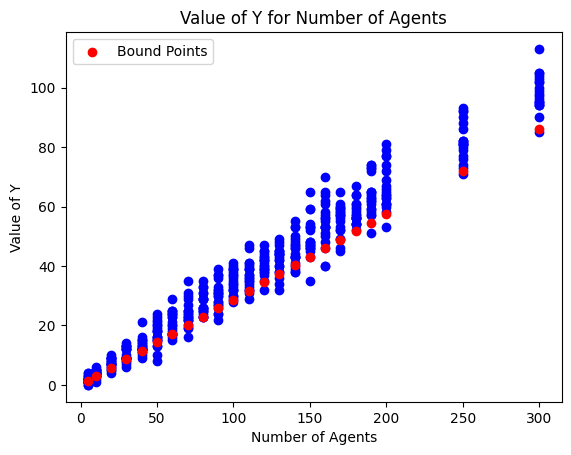

In [ ]:
amaj_generate_data(a_evidence=6, b_evidence=5, p_competence=0.7)

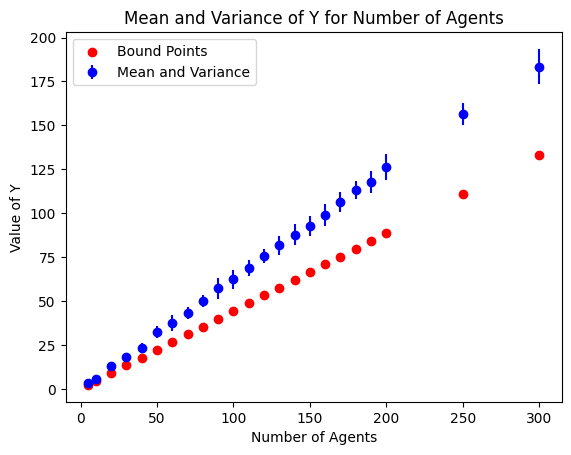

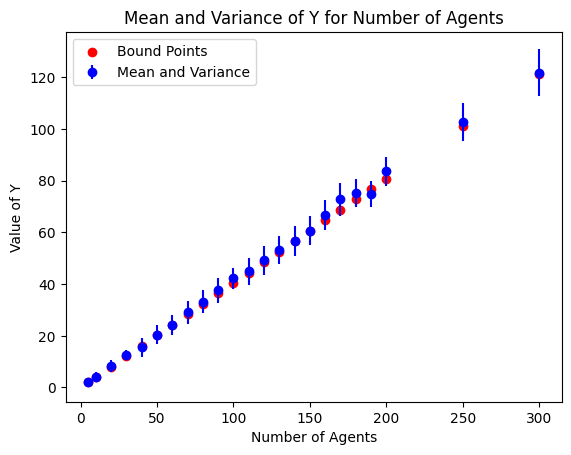

In [ ]:
amaj_generate_data_mean(a_evidence=8, b_evidence=5, p_competence=0.7)


amaj_generate_data_mean(a_evidence=8, b_evidence=5, p_competence=0.6)

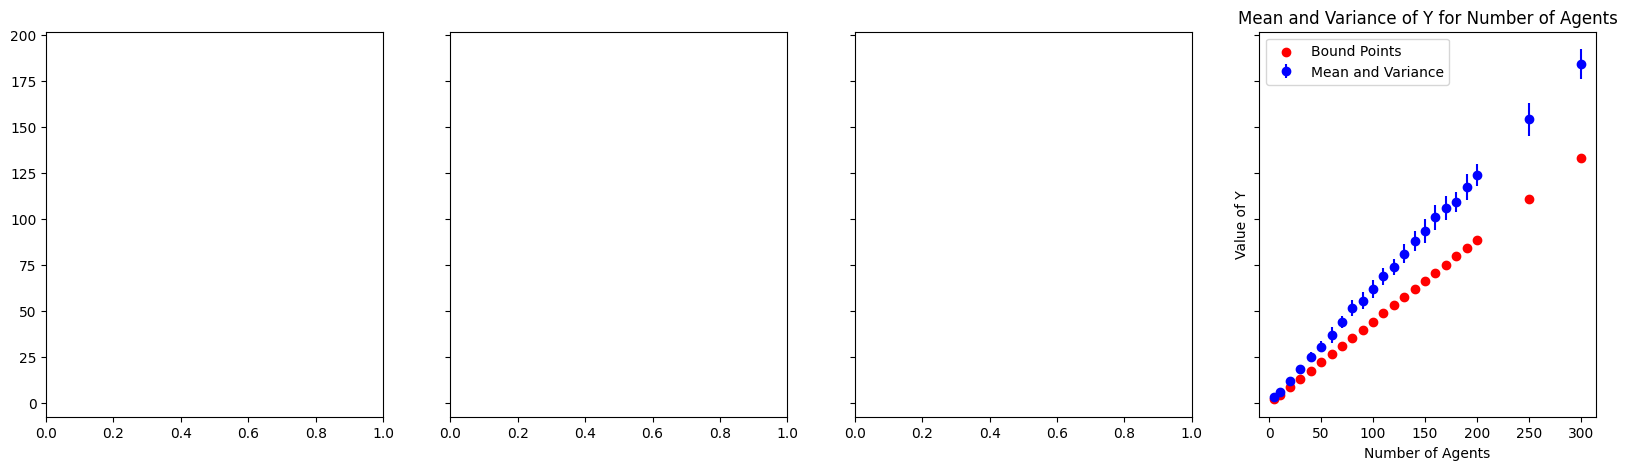

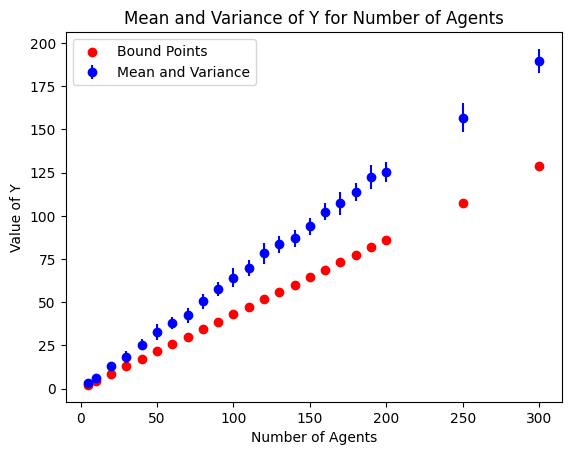

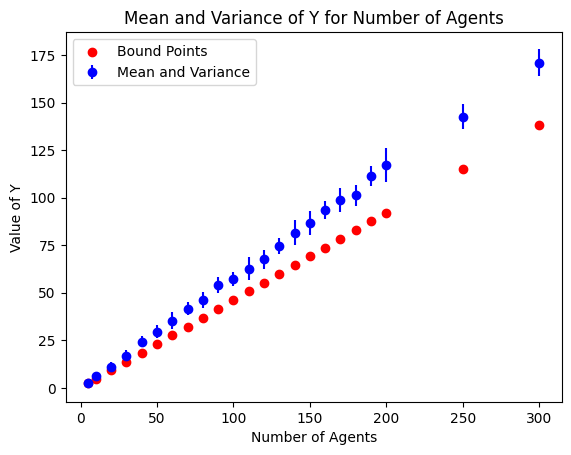

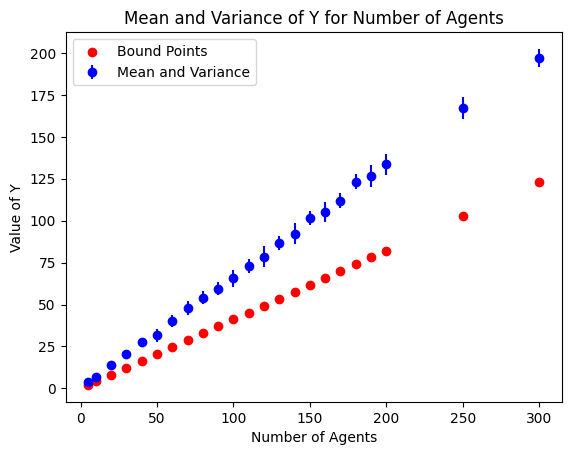

<Figure size 640x480 with 0 Axes>

In [ ]:

# Define the parameter sets
parameter_sets = [
    (8, 5, 0.7),
    (5, 3, 0.7),
    (9, 3, 0.4),
    (7, 6, 0.9)
]

# Create a row of mini plots
fig, axes = plt.subplots(1, len(parameter_sets), figsize=(20, 5), sharey=True)

# Generate data and plot for each parameter set
for ax, params in zip(axes, parameter_sets):
    generate_data_mean(*params)

# Adjust layout
plt.tight_layout()
plt.show()


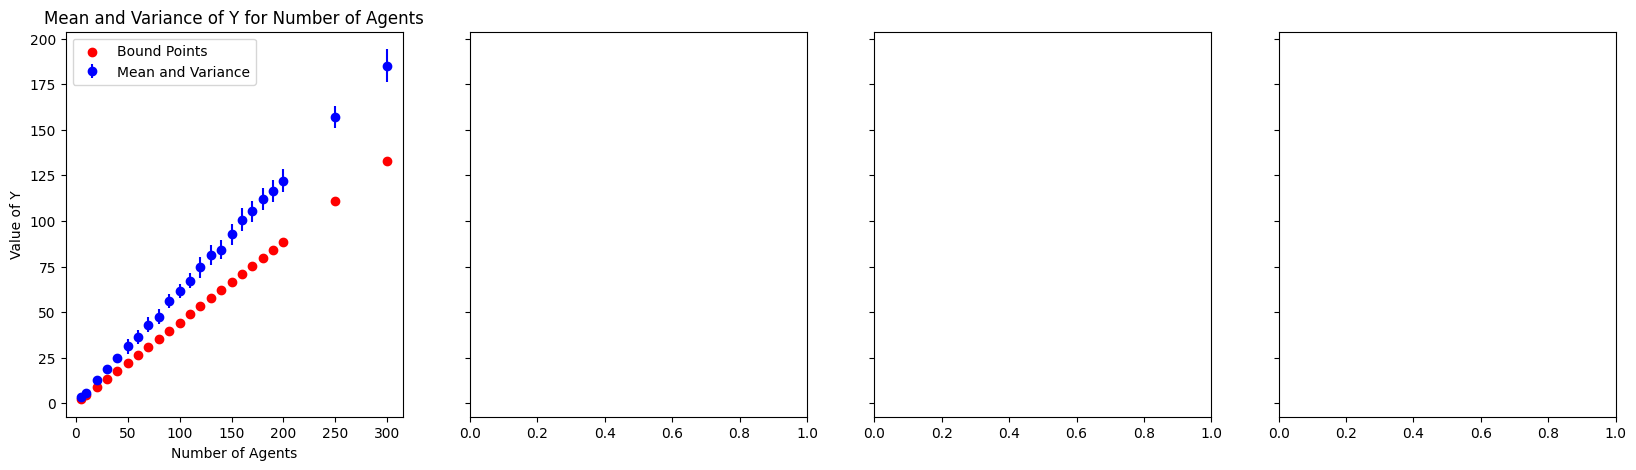

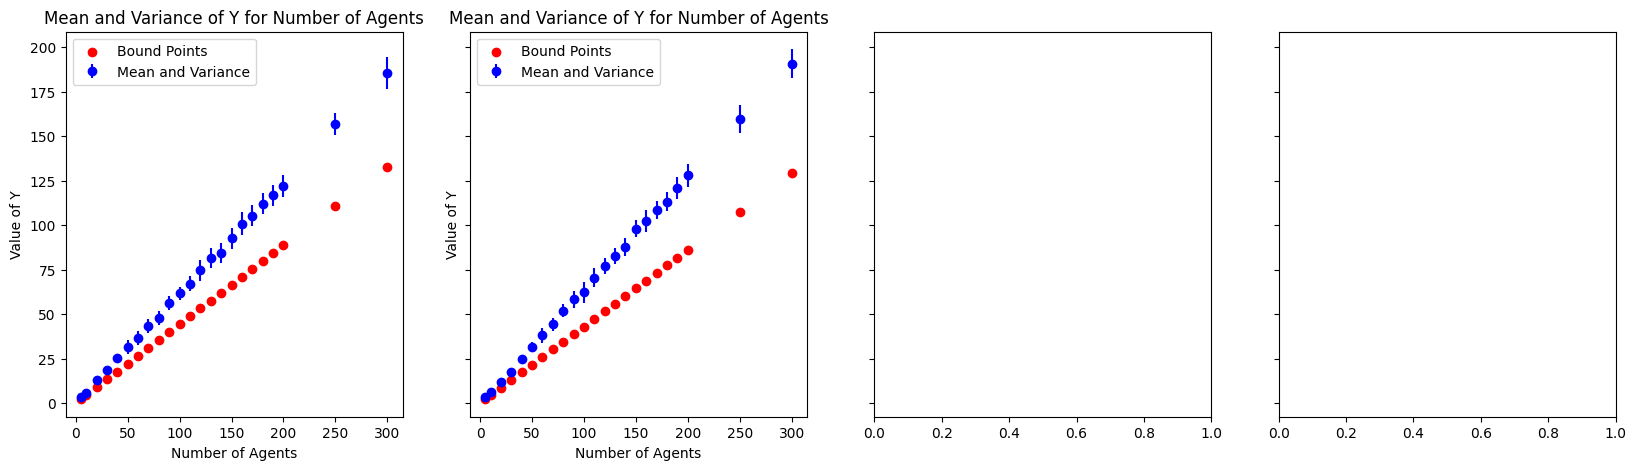

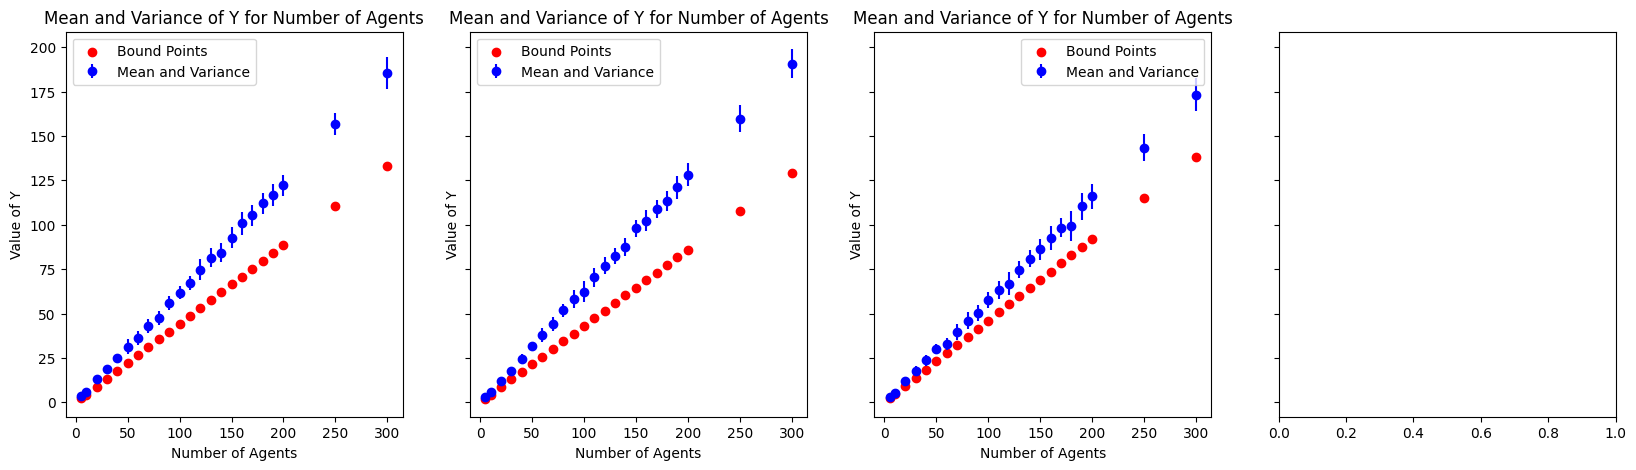

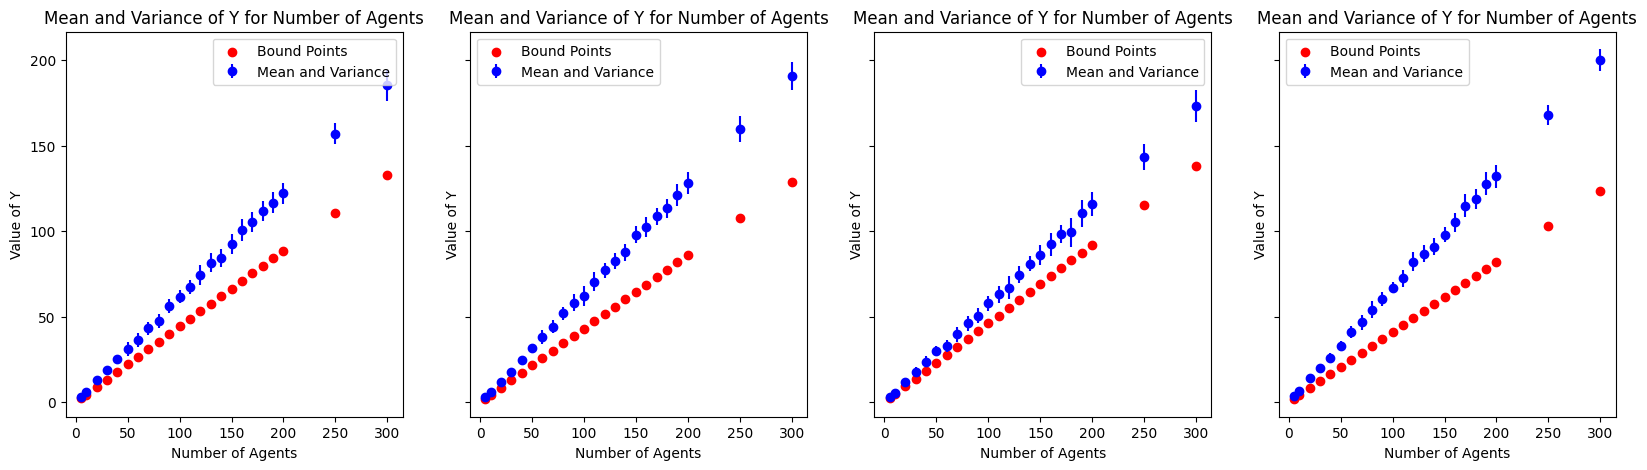

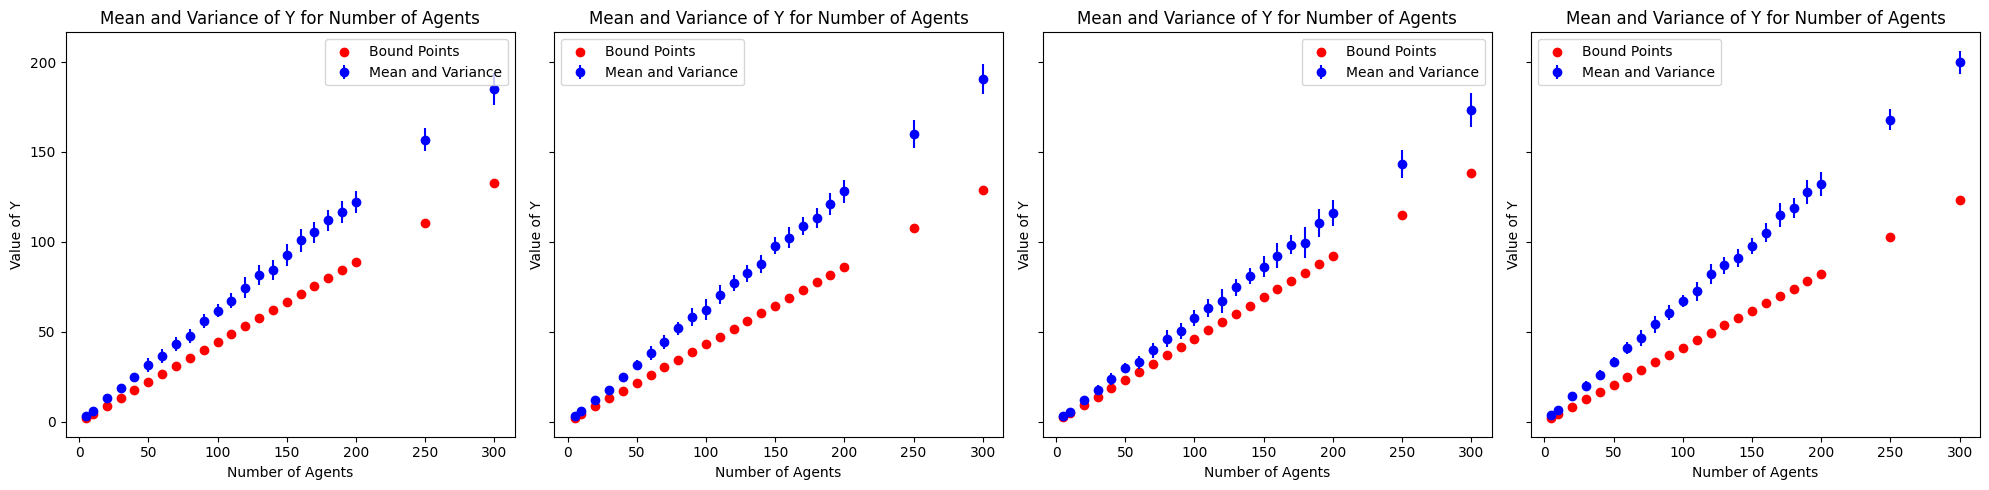

In [ ]:
#Define a context manager to temporarily change the plotting axis
class temporary_figure:
    def __init__(self, ax):
        self.ax = ax

    def __enter__(self):
        self.original_figure = plt.gcf()
        self.original_ax = plt.gca()
        plt.sca(self.ax)

    def __exit__(self, exc_type, exc_value, traceback):
        plt.sca(self.original_ax)
        plt.figure(self.original_figure.number)

# Define the parameter sets
parameter_sets = [
    (8, 5, 0.7),
    (5, 3, 0.7),
    (9, 3, 0.4),
    (7, 6, 0.9)
]

# Create a row of mini plots
fig, axes = plt.subplots(1, len(parameter_sets), figsize=(20, 5), sharey=True)

# Generate data and plot for each parameter set
for ax, params in zip(axes, parameter_sets):
    with temporary_figure(ax):
        generate_data_mean(*params)

# Adjust layout
plt.tight_layout()
plt.show()

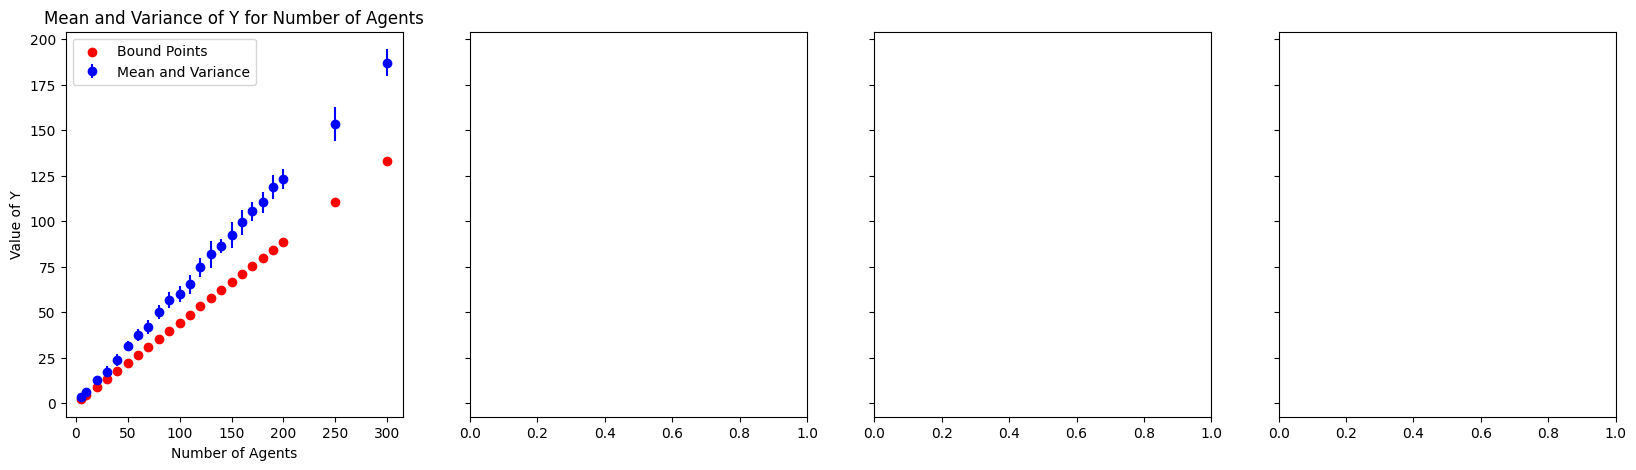

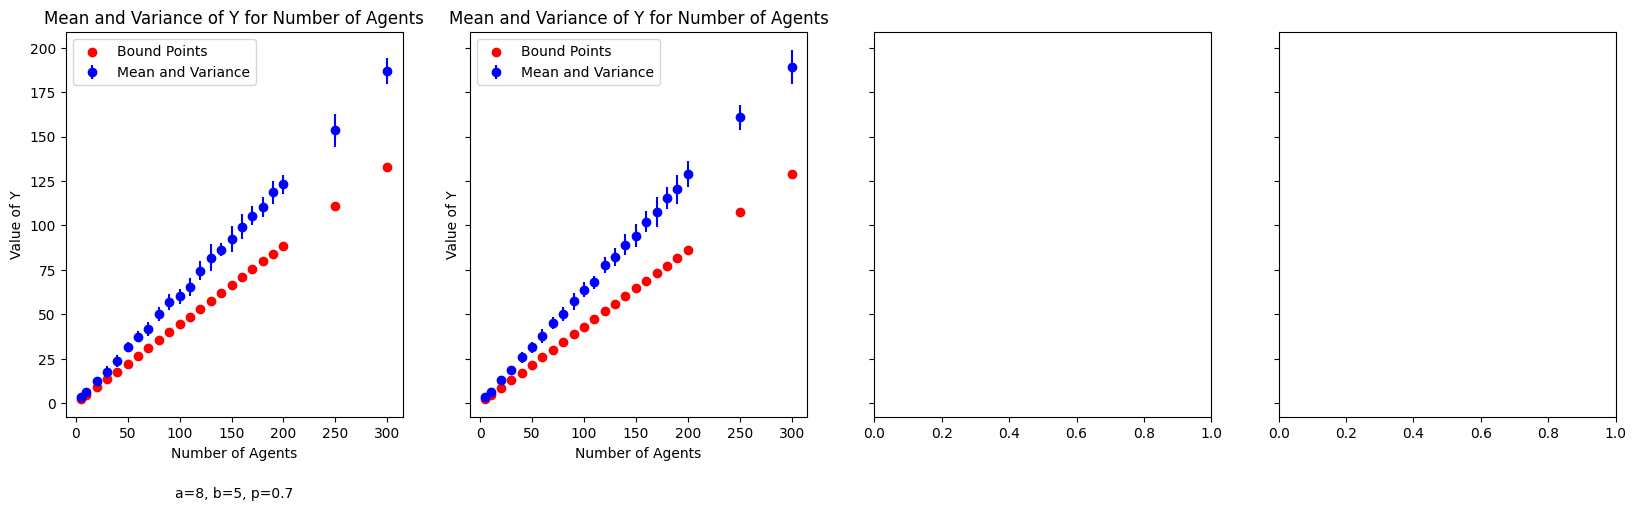

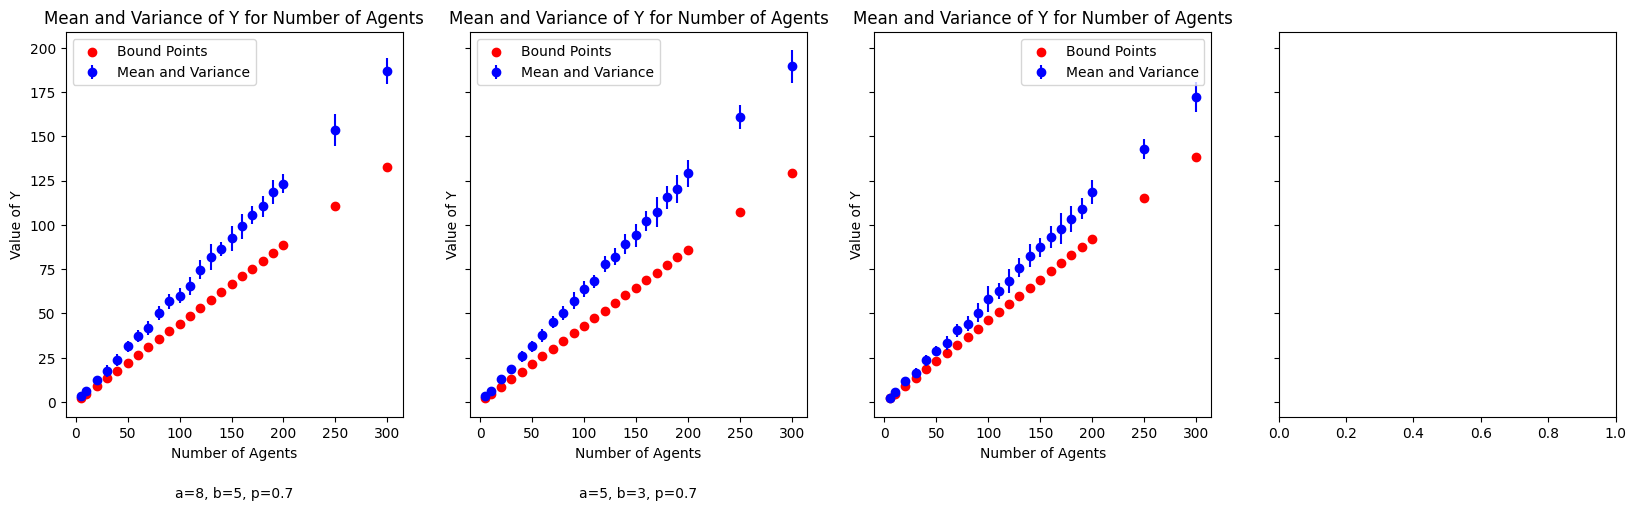

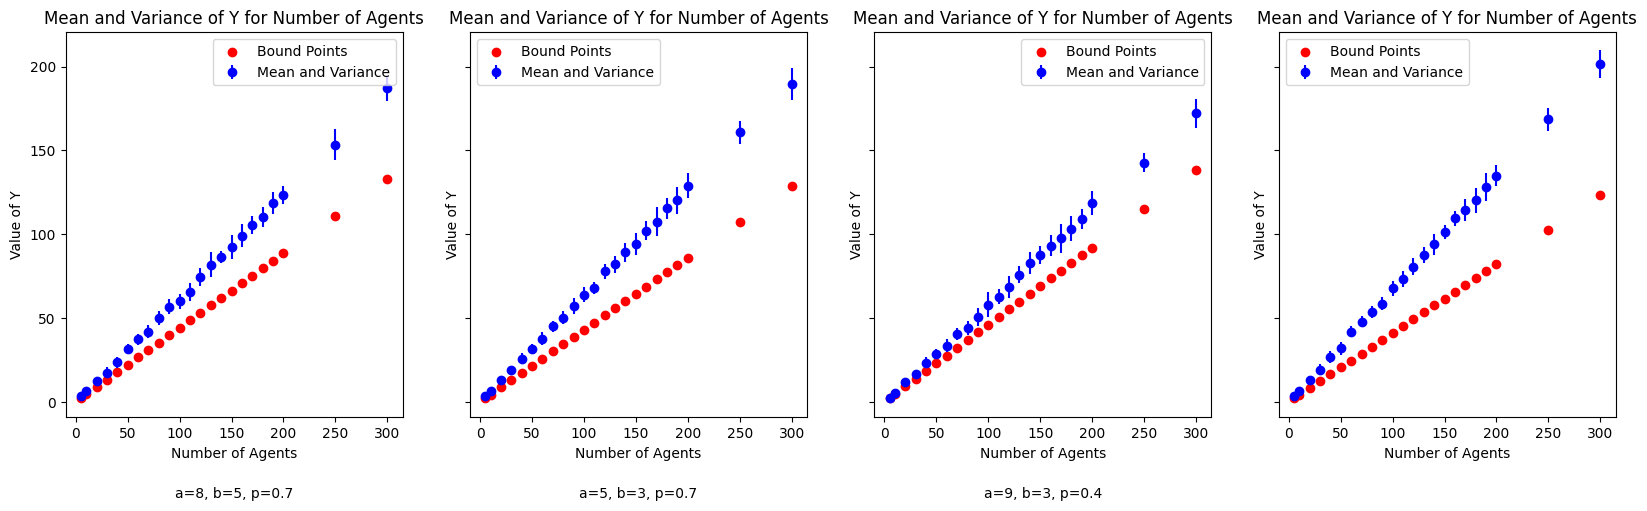

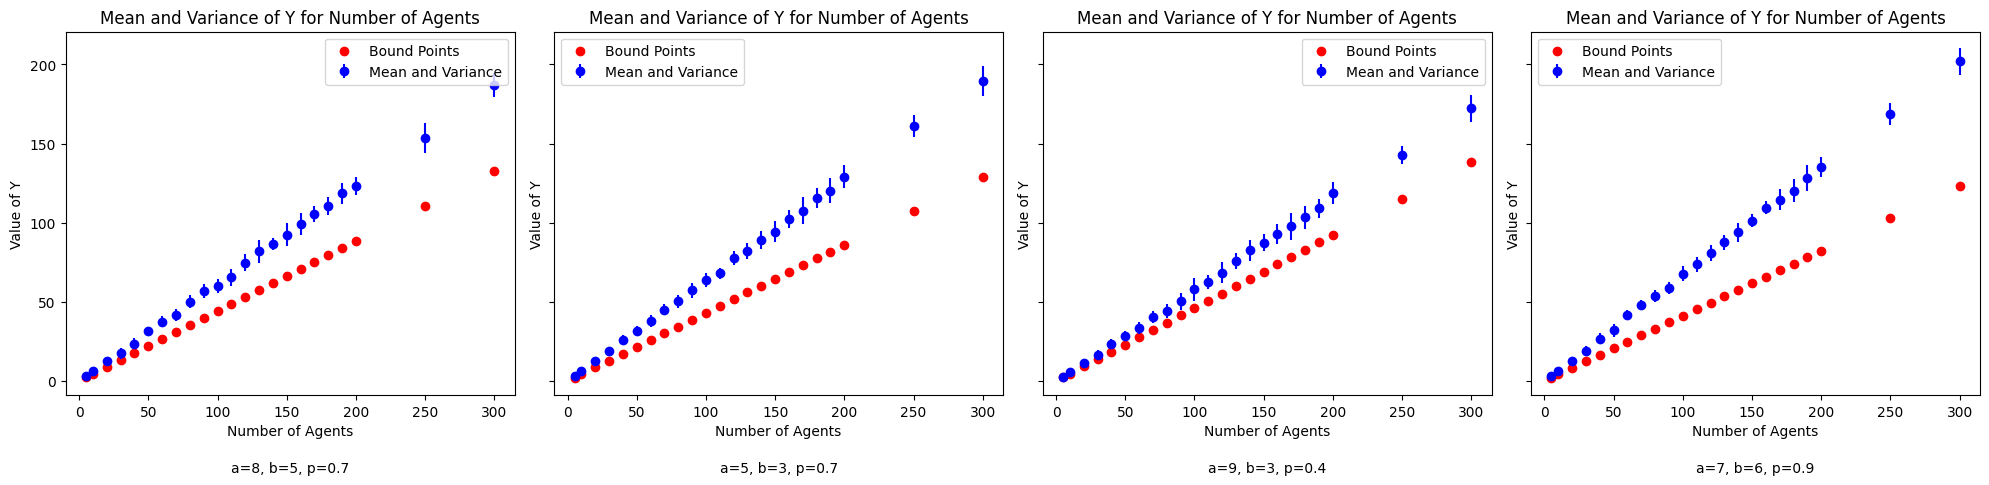

In [ ]:
# Define a context manager to temporarily change the plotting axis
class temporary_figure:
    def __init__(self, ax):
        self.ax = ax

    def __enter__(self):
        self.original_figure = plt.gcf()
        self.original_ax = plt.gca()
        plt.sca(self.ax)

    def __exit__(self, exc_type, exc_value, traceback):
        plt.sca(self.original_ax)
        plt.figure(self.original_figure.number)

# Define the parameter sets
parameter_sets = [
    (8, 5, 0.7),
    (5, 3, 0.7),
    (9, 3, 0.4),
    (7, 6, 0.9)
]

# Create a row of mini plots
fig, axes = plt.subplots(1, len(parameter_sets), figsize=(20, 5), sharey=True)

# Generate data and plot for each parameter set
for ax, params in zip(axes, parameter_sets):
    with temporary_figure(ax):
        generate_data_mean(*params)
    ax.text(0.5, -0.2, f'a={params[0]}, b={params[1]}, p={params[2]}', transform=ax.transAxes, ha='center', va='center', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()